### Librerias

In [5]:
#Cargando librerias
import pandas as pd
import numpy as np
import cv2
import os
import random
from matplotlib import pyplot as plt
import matplotlib.cm as cm

import keras
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from keras.models import load_model
from keras.preprocessing import image
from keras.models import Model
from keras import backend as K
from scipy.special import rel_entr

### Cargando el modelo y seleccionando las capas convolucionales

In [6]:
#Semilla
np.random.seed(322)

#Cargando el modelo y el estimulo
model = load_model("D:/Documentos/modelos/CONV-GRAD-CAM.h5")
estimulo = cv2.imread("D:/Documentos/6/19.png")

#Procesando el estimulo
img_array = np.asarray(estimulo)
tamanio = cv2.resize(img_array, (224, 224))
gray = cv2.cvtColor(tamanio, cv2.COLOR_BGR2GRAY)
hist = cv2.equalizeHist(gray)
img = hist/255
img = img.reshape(1, 224, 224, 1)

capa1 = Model(inputs=model.layers[0].input, outputs=model.layers[0].output)
capa2 = Model(inputs=model.layers[0].input, outputs=model.layers[2].output)

### Generando el mapa de activación

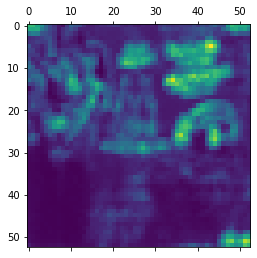

In [7]:
prediccion = model.predict_classes(img)

#Seleccionar la ultima capa
clase_output = model.output[:, prediccion[0]]
last_conv_layer = model.get_layer('max_pooling2d_1')

# Gradiente para la clase predicha a tráves de la ultima capa convolucional
grads = K.gradients(clase_output, last_conv_layer.output)[0]

# Cada entrada es la intensidad media del gradiente sobre un canal del mapa de características específico
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Accede a los valores que acabamos de definir para la imagen de muestra
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# Valores de pooled_grads_value, conv_layer_output_value dada la imagen de entrada
pooled_grads_value, conv_layer_output_value = iterate([img])

# Multiplicamos cada canal de la matriz del mapa de características por la 'importancia'
# de este canal con respecto a la imagen de entrada
for i in range(32): #EL RANGO DE VALORES VA DESDE 1 HASTA EL NUMERO DE FILTROS DE LA ULTIMA CAPA CONVOLUCIONAL
    #La media por el canal del mapa de características resultante es el mapa de calor del CAM
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
#Generación del mapa de calor al tamaño del filtro
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
fijaciones = heatmap 

# Display heatmap
plt.matshow(heatmap)
plt.show()

### Calculo de la distancia Kulback-Leibler

In [8]:
#Parametros del dataset a cargar
CATEGORIA = 6
ESTIMULO = 19
FIJACIONES = 150

# We load the original image
img = keras.preprocessing.image.img_to_array(estimulo)

#Estableciendo los máximos puntos de activacion del filtro
y = []
x = []
for i in range(FIJACIONES):
    i,j = np.unravel_index(fijaciones.argmax(), fijaciones.shape)
    x.append(j+ random.random())
    y.append(i +random.random())
    fijaciones[i][j]=0
    
#Redimensionando fijaciones
pred_x =[]
pred_y= []

for i in range(len(x)):
    pred_x.append((x[i]*img.shape[1])/fijaciones.shape[1])
    pred_y.append((y[i]*img.shape[0])/fijaciones.shape[0])


#Lectura del dataset general
df = pd.read_csv("D:/Documentos/dataset.csv")
df = df[df["category"]==CATEGORIA]
df  = df[df["filenumber"]==ESTIMULO].reset_index()


#Determinancion de las coordenadas reales mas cercanas a las predichas
real_x = []
real_y = []
for i in range(len(pred_x)):
    for j in range(len(df)):
        if j==0:
            d_temp = np.sqrt(pow(pred_x[i]-df["x"][j], 2)+pow(pred_y[i]-df["y"][j], 2))
            x = df["x"][j]
            y = df["y"][j]
            d = d_temp
        else:
            d_temp = np.sqrt(pow(pred_x[i]-df["x"][j], 2)+pow(pred_y[i]-df["y"][j], 2))
            if d_temp < d:
                d = d_temp
                x = df["x"][j]
                y = df["y"][j]
    for k in range(len(df)):
        if x == df["x"][k]:
            if y == df["y"][k]:
                df["x"][k]=100000
                df["y"][k]=100000               
    real_x.append(x)
    real_y.append(y)

 
#normalizacion de coordenadas (distribución 0, 1)
real_nx = []
for i in range(len(real_x)):
    if real_x[i]==0.0:
        real_x[i]=10
    real_nx.append(real_x[i]/sum(real_x))


real_ny = []
for i in range(len(real_y)):
    if real_y[i]==0.0:
        real_y[i]=10
    real_ny.append(real_y[i]/sum(real_y))


pred_nx = []
for i in range(len(pred_x)):
    if pred_x[i]==0.0:
        pred_x[i]=10
    pred_nx.append(pred_x[i]/sum(pred_x))
    
pred_ny = []
for i in range(len(pred_y)):
    if pred_y[i]==0.0:
        pred_y[i]=10
    pred_ny.append(pred_y[i]/sum(pred_y))

    
# example of calculating the kl divergence (relative entropy) with scipy
# calculate (P || Q)
kl_pq = rel_entr(real_ny, pred_ny)
print('KL(Py || Qy): %.3f nats' % sum(kl_pq))


# calculate (P || Q)
kl_pq = rel_entr(real_nx, pred_nx)
print('KL(Px || Qx): %.3f nats' % sum(kl_pq))

<ipython-input-8-db7d3af8b5cc>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["x"][k]=100000
<ipython-input-8-db7d3af8b5cc>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y"][k]=100000


KL(Py || Qy): 0.216 nats
KL(Px || Qx): 0.022 nats


### Gráfico de fijaciones reales vs predichas

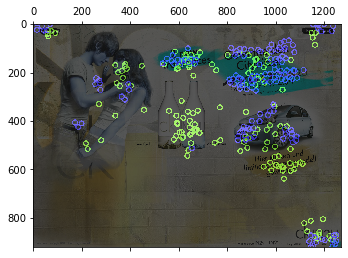

In [9]:
estimulo =  cv2.imread("D:/Documentos/Estimulos/"+str(ESTIMULO)+".png")

image = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)+20
for i in range(FIJACIONES):
    cv2.circle(image, (int(real_x[i]), int(real_y[i])), 10, (134, 240, 53), 3) 
    cv2.circle(image, (int(pred_x[i]), int(pred_y[i])), 10, (74, 60, 255), 3) 
        
superimposed_img = img * 0.4 + image 
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
plt.matshow( superimposed_img)
plt.show()